### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

# Clase 1: rho1, etiqueta = 1
a_test = np.random.uniform(0, 1, int(n_test/2))
for a in a_test:
    rho, label = ρ1(a)
    data_test.append((rho, label))

# Clase 2: rho2, etiqueta = 2
b_test = np.random.uniform(0, 1, int(n_test/2))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 50
data = []

# Familia 1 → usa ρ1(a), etiqueta = 1
a_values = np.random.uniform(0, 1, int(n_samples/2))
for a in a_values:
    rho, label = ρ1(a)  # rho es matriz 4x4, label = 1
    data.append((rho, label))

# Familia 2 → usa ρ2(b), etiqueta = 2
b_values = np.random.uniform(0, 1, int(n_samples/2))
for b in b_values:
    rho, label = ρ2(b)  # rho es matriz 4x4, label = 2
    data.append((rho, label))

# Mezclar y dividir: 80% entrenamiento, 20% validación
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 5  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 1000
batch_size = int(len(data_train)*0.2)
val_batch_size=int(0.2*batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 100
min_delta = 1e-6
best_val_loss = float('inf')
patience_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
test_suc_history = []
test_err_history = []
test_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):
    
    # Seleccionar un batch aleatorio de data_train
    batch = random.sample(data_train, batch_size)
    
    # Paso de entrenamiento con el batch
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)
    
    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)




    # Early stopping
    if best_val_loss - val_loss > min_delta:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"⏹️ Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        break

    # Evaluación en train y test
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_test, err_test, inc_test = evaluate_model(params, data_test)

    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    test_suc_history.append(suc_test)
    test_err_history.append(err_test)
    test_inc_history.append(inc_test)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"test_suc={suc_test:.3f}, test_err={err_test:.3f}, test_inc={inc_test:.3f}")

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
print(f"  Éxito promedio     = {suc_test:.4f}")
print(f"  Error promedio     = {err_test:.4f}")
print(f"  Inconcluso promedio = {inc_test:.4f}")




Entrenando:   0%|          | 0/1000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/1000 [06:59<116:17:06, 419.05s/it]

Entrenando:   0%|          | 2/1000 [13:54<115:35:03, 416.94s/it]

Entrenando:   0%|          | 3/1000 [20:51<115:28:35, 416.97s/it]

Entrenando:   0%|          | 4/1000 [27:48<115:19:01, 416.81s/it]

Entrenando:   0%|          | 5/1000 [34:44<115:10:17, 416.70s/it]

Entrenando:   1%|          | 6/1000 [41:40<115:01:13, 416.57s/it]

Entrenando:   1%|          | 7/1000 [48:36<114:50:23, 416.34s/it]

Entrenando:   1%|          | 8/1000 [55:33<114:43:48, 416.36s/it]

Entrenando:   1%|          | 9/1000 [1:02:30<114:41:55, 416.67s/it]

Entrenando:   1%|          | 10/1000 [1:09:28<114:42:02, 417.09s/it]

Entrenando:   1%|          | 11/1000 [1:16:27<114:42:10, 417.52s/it]

Entrenando:   1%|          | 12/1000 [1:23:24<114:32:39, 417.37s/it]

Entrenando:   1%|▏         | 13/1000 [1:30:20<114:21:36, 417.12s/it]

Entrenando:   1%|▏         | 14/1000 [1:37:17<114:15:30, 417.17s/it]

Entrenando:   2%|▏         | 15/1000 [1:44:16<114:16:04, 417.63s/it]

Entrenando:   2%|▏         | 16/1000 [1:51:12<114:02:55, 417.25s/it]

Entrenando:   2%|▏         | 17/1000 [1:58:09<113:52:31, 417.04s/it]

Entrenando:   2%|▏         | 18/1000 [2:05:07<113:51:13, 417.39s/it]

Entrenando:   2%|▏         | 19/1000 [2:12:04<113:39:47, 417.11s/it]

Entrenando:   2%|▏         | 20/1000 [2:19:04<113:47:59, 418.04s/it]

Entrenando:   2%|▏         | 21/1000 [2:26:01<113:36:35, 417.77s/it]

Entrenando:   2%|▏         | 22/1000 [2:32:59<113:32:56, 417.97s/it]

Entrenando:   2%|▏         | 23/1000 [2:39:58<113:28:15, 418.11s/it]

Entrenando:   2%|▏         | 24/1000 [2:46:57<113:25:05, 418.35s/it]

Entrenando:   2%|▎         | 25/1000 [2:53:55<113:15:11, 418.17s/it]

Entrenando:   3%|▎         | 26/1000 [3:00:53<113:11:19, 418.36s/it]

Entrenando:   3%|▎         | 27/1000 [3:07:50<112:55:22, 417.80s/it]

Entrenando:   3%|▎         | 28/1000 [3:14:48<112:51:38, 418.00s/it]

Entrenando:   3%|▎         | 29/1000 [3:21:45<112:36:27, 417.50s/it]

Entrenando:   3%|▎         | 30/1000 [3:28:41<112:25:23, 417.24s/it]

Entrenando:   3%|▎         | 31/1000 [3:35:38<112:14:56, 417.02s/it]

Entrenando:   3%|▎         | 32/1000 [3:42:35<112:06:50, 416.95s/it]

Entrenando:   3%|▎         | 33/1000 [3:49:41<112:46:15, 419.83s/it]

Entrenando:   3%|▎         | 34/1000 [3:57:16<115:30:42, 430.48s/it]

Entrenando:   4%|▎         | 35/1000 [4:04:52<117:22:29, 437.87s/it]

Entrenando:   4%|▎         | 36/1000 [4:12:26<118:32:46, 442.70s/it]

Entrenando:   4%|▎         | 37/1000 [4:20:00<119:24:03, 446.36s/it]

Entrenando:   4%|▍         | 38/1000 [4:27:32<119:41:48, 447.93s/it]

Entrenando:   4%|▍         | 39/1000 [4:34:30<117:10:05, 438.92s/it]

Entrenando:   4%|▍         | 40/1000 [4:41:26<115:14:22, 432.15s/it]

Entrenando:   4%|▍         | 41/1000 [4:48:23<113:51:38, 427.42s/it]

Entrenando:   4%|▍         | 42/1000 [4:55:21<112:59:46, 424.62s/it]

Entrenando:   4%|▍         | 43/1000 [5:02:17<112:13:29, 422.16s/it]

Entrenando:   4%|▍         | 44/1000 [5:09:14<111:42:34, 420.66s/it]

Entrenando:   4%|▍         | 45/1000 [5:16:11<111:14:09, 419.32s/it]

Entrenando:   5%|▍         | 46/1000 [5:23:08<110:58:37, 418.78s/it]

Entrenando:   5%|▍         | 47/1000 [5:30:05<110:44:31, 418.33s/it]

Entrenando:   5%|▍         | 48/1000 [5:37:02<110:31:23, 417.94s/it]

Entrenando:   5%|▍         | 49/1000 [5:44:00<110:20:49, 417.72s/it]

Entrenando:   5%|▌         | 50/1000 [5:50:58<110:14:57, 417.79s/it]

Iter  50: train_loss=2.2844, val_loss=3.0104, train_suc=0.517, train_err=0.266, train_inc=0.217 | test_suc=0.469, test_err=0.270, test_inc=0.261


Entrenando:   5%|▌         | 51/1000 [5:57:55<110:05:00, 417.60s/it]

Entrenando:   5%|▌         | 52/1000 [6:04:53<110:02:47, 417.90s/it]

Entrenando:   5%|▌         | 53/1000 [6:11:50<109:52:28, 417.69s/it]

Entrenando:   5%|▌         | 54/1000 [6:19:10<111:27:45, 424.17s/it]

Entrenando:   6%|▌         | 55/1000 [6:26:45<113:47:52, 433.52s/it]

Entrenando:   6%|▌         | 56/1000 [6:34:21<115:24:46, 440.13s/it]

Entrenando:   6%|▌         | 57/1000 [6:41:56<116:28:54, 444.68s/it]

Entrenando:   6%|▌         | 58/1000 [6:49:08<115:20:48, 440.82s/it]

Entrenando:   6%|▌         | 59/1000 [6:56:10<113:46:29, 435.27s/it]

Entrenando:   6%|▌         | 60/1000 [7:03:09<112:21:53, 430.33s/it]

Entrenando:   6%|▌         | 61/1000 [7:10:07<111:15:22, 426.54s/it]

Entrenando:   6%|▌         | 62/1000 [7:17:03<110:19:34, 423.43s/it]

Entrenando:   6%|▋         | 63/1000 [7:24:01<109:46:11, 421.74s/it]

Entrenando:   6%|▋         | 64/1000 [7:30:58<109:17:26, 420.35s/it]

Entrenando:   6%|▋         | 65/1000 [7:37:56<109:01:50, 419.80s/it]

Entrenando:   7%|▋         | 66/1000 [7:44:53<108:42:18, 418.99s/it]

Entrenando:   7%|▋         | 67/1000 [7:51:49<108:19:11, 417.95s/it]

Entrenando:   7%|▋         | 68/1000 [7:58:47<108:15:16, 418.15s/it]

Entrenando:   7%|▋         | 69/1000 [8:05:46<108:08:48, 418.18s/it]

Entrenando:   7%|▋         | 70/1000 [8:12:44<108:02:08, 418.20s/it]

Entrenando:   7%|▋         | 71/1000 [8:19:42<107:55:06, 418.20s/it]

Entrenando:   7%|▋         | 72/1000 [8:26:40<107:45:01, 418.00s/it]

Entrenando:   7%|▋         | 73/1000 [8:33:37<107:36:07, 417.87s/it]

Entrenando:   7%|▋         | 74/1000 [8:40:34<107:25:50, 417.66s/it]

Entrenando:   8%|▊         | 75/1000 [8:47:33<107:21:53, 417.85s/it]

Entrenando:   8%|▊         | 76/1000 [8:54:31<107:15:05, 417.86s/it]

Entrenando:   8%|▊         | 77/1000 [9:01:27<107:01:45, 417.45s/it]

Entrenando:   8%|▊         | 78/1000 [9:08:26<107:02:40, 417.96s/it]

Entrenando:   8%|▊         | 79/1000 [9:16:02<109:48:00, 429.19s/it]

Entrenando:   8%|▊         | 80/1000 [9:23:37<111:43:06, 437.16s/it]

Entrenando:   8%|▊         | 81/1000 [9:31:12<112:54:59, 442.33s/it]

Entrenando:   8%|▊         | 82/1000 [9:38:46<113:42:45, 445.93s/it]

Entrenando:   8%|▊         | 83/1000 [9:45:43<111:22:13, 437.22s/it]

Entrenando:   8%|▊         | 84/1000 [9:52:41<109:47:01, 431.46s/it]

Entrenando:   8%|▊         | 85/1000 [9:59:38<108:32:14, 427.03s/it]

Entrenando:   9%|▊         | 86/1000 [10:06:34<107:35:01, 423.74s/it]

Entrenando:   9%|▊         | 87/1000 [10:13:31<106:58:37, 421.81s/it]

Entrenando:   9%|▉         | 88/1000 [10:20:30<106:38:22, 420.95s/it]

Entrenando:   9%|▉         | 89/1000 [10:27:27<106:12:50, 419.73s/it]

Entrenando:   9%|▉         | 90/1000 [10:34:25<105:56:41, 419.12s/it]

Entrenando:   9%|▉         | 91/1000 [10:41:22<105:40:51, 418.54s/it]

Entrenando:   9%|▉         | 92/1000 [10:48:18<105:24:53, 417.94s/it]

Entrenando:   9%|▉         | 93/1000 [10:55:16<105:15:49, 417.81s/it]

Entrenando:   9%|▉         | 94/1000 [11:02:12<105:03:13, 417.43s/it]

Entrenando:  10%|▉         | 95/1000 [11:09:10<104:55:14, 417.36s/it]

Entrenando:  10%|▉         | 96/1000 [11:16:06<104:44:44, 417.13s/it]

Entrenando:  10%|▉         | 97/1000 [11:23:03<104:34:06, 416.88s/it]

Entrenando:  10%|▉         | 98/1000 [11:30:01<104:33:05, 417.28s/it]

Entrenando:  10%|▉         | 99/1000 [11:36:57<104:23:06, 417.08s/it]

Entrenando:  10%|█         | 100/1000 [11:43:54<104:14:02, 416.94s/it]

Iter 100: train_loss=1.6595, val_loss=2.6256, train_suc=0.553, train_err=0.201, train_inc=0.246 | test_suc=0.502, test_err=0.192, test_inc=0.306


Entrenando:  10%|█         | 101/1000 [11:50:52<104:11:51, 417.25s/it]

Entrenando:  10%|█         | 102/1000 [11:57:50<104:09:33, 417.57s/it]

Entrenando:  10%|█         | 103/1000 [12:04:49<104:09:31, 418.03s/it]

Entrenando:  10%|█         | 104/1000 [12:11:46<103:57:55, 417.72s/it]

Entrenando:  10%|█         | 105/1000 [12:18:42<103:41:43, 417.10s/it]

Entrenando:  11%|█         | 106/1000 [12:25:39<103:33:15, 417.00s/it]

Entrenando:  11%|█         | 107/1000 [12:32:36<103:27:26, 417.07s/it]

Entrenando:  11%|█         | 108/1000 [12:39:32<103:17:48, 416.89s/it]

Entrenando:  11%|█         | 109/1000 [12:46:31<103:18:15, 417.39s/it]

Entrenando:  11%|█         | 110/1000 [12:53:29<103:15:47, 417.69s/it]

Entrenando:  11%|█         | 111/1000 [13:00:28<103:10:52, 417.83s/it]

Entrenando:  11%|█         | 112/1000 [13:07:25<103:02:40, 417.75s/it]

Entrenando:  11%|█▏        | 113/1000 [13:14:24<102:59:12, 417.98s/it]

Entrenando:  11%|█▏        | 114/1000 [13:21:21<102:47:41, 417.68s/it]

Entrenando:  12%|█▏        | 115/1000 [13:28:17<102:32:52, 417.14s/it]

Entrenando:  12%|█▏        | 116/1000 [13:35:15<102:29:50, 417.41s/it]

Entrenando:  12%|█▏        | 117/1000 [13:42:13<102:27:42, 417.74s/it]

Entrenando:  12%|█▏        | 118/1000 [13:49:12<102:24:33, 418.00s/it]

Entrenando:  12%|█▏        | 119/1000 [13:56:08<102:12:15, 417.63s/it]

Entrenando:  12%|█▏        | 120/1000 [14:03:06<102:04:57, 417.61s/it]

Entrenando:  12%|█▏        | 121/1000 [14:10:03<101:53:24, 417.30s/it]

Entrenando:  12%|█▏        | 122/1000 [14:17:39<104:36:28, 428.92s/it]

Entrenando:  12%|█▏        | 123/1000 [14:25:13<106:22:09, 436.64s/it]

Entrenando:  12%|█▏        | 124/1000 [14:32:48<107:35:56, 442.19s/it]

Entrenando:  12%|█▎        | 125/1000 [14:40:24<108:27:54, 446.26s/it]

Entrenando:  13%|█▎        | 126/1000 [14:48:01<109:07:51, 449.51s/it]

Entrenando:  13%|█▎        | 127/1000 [14:55:36<109:23:45, 451.12s/it]

Entrenando:  13%|█▎        | 128/1000 [15:03:11<109:33:35, 452.31s/it]

Entrenando:  13%|█▎        | 129/1000 [15:10:47<109:41:26, 453.37s/it]

Entrenando:  13%|█▎        | 130/1000 [15:18:22<109:42:28, 453.96s/it]

Entrenando:  13%|█▎        | 131/1000 [15:25:20<106:58:54, 443.19s/it]

Entrenando:  13%|█▎        | 132/1000 [15:32:17<104:55:15, 435.16s/it]

Entrenando:  13%|█▎        | 133/1000 [15:39:14<103:30:13, 429.77s/it]

Entrenando:  13%|█▎        | 134/1000 [15:46:11<102:27:51, 425.95s/it]

Entrenando:  14%|█▎        | 135/1000 [15:53:07<101:39:02, 423.05s/it]

Entrenando:  14%|█▎        | 136/1000 [16:00:05<101:10:21, 421.55s/it]

Entrenando:  14%|█▎        | 137/1000 [16:07:03<100:47:21, 420.44s/it]

Entrenando:  14%|█▍        | 138/1000 [16:13:59<100:21:34, 419.13s/it]

Entrenando:  14%|█▍        | 139/1000 [16:20:56<100:02:49, 418.32s/it]

Entrenando:  14%|█▍        | 140/1000 [16:27:53<99:51:02, 417.98s/it] 

Entrenando:  14%|█▍        | 141/1000 [16:34:50<99:39:26, 417.66s/it]

Entrenando:  14%|█▍        | 142/1000 [16:41:48<99:33:44, 417.74s/it]

Entrenando:  14%|█▍        | 143/1000 [16:48:45<99:25:26, 417.65s/it]

Entrenando:  14%|█▍        | 144/1000 [16:55:44<99:21:32, 417.86s/it]

Entrenando:  14%|█▍        | 145/1000 [17:02:40<99:06:55, 417.33s/it]

Entrenando:  15%|█▍        | 146/1000 [17:09:37<98:59:50, 417.32s/it]

Entrenando:  15%|█▍        | 147/1000 [17:16:33<98:48:57, 417.04s/it]

Entrenando:  15%|█▍        | 148/1000 [17:23:32<98:48:38, 417.51s/it]

Entrenando:  15%|█▍        | 149/1000 [17:30:30<98:43:22, 417.63s/it]

Entrenando:  15%|█▌        | 150/1000 [17:37:26<98:29:48, 417.16s/it]

Iter 150: train_loss=1.6038, val_loss=2.5136, train_suc=0.556, train_err=0.182, train_inc=0.263 | test_suc=0.505, test_err=0.169, test_inc=0.326


Entrenando:  15%|█▌        | 151/1000 [17:44:23<98:22:11, 417.12s/it]

Entrenando:  15%|█▌        | 152/1000 [17:51:22<98:23:17, 417.69s/it]

Entrenando:  15%|█▌        | 153/1000 [17:58:18<98:11:17, 417.33s/it]

Entrenando:  15%|█▌        | 154/1000 [18:05:17<98:09:11, 417.67s/it]

Entrenando:  16%|█▌        | 155/1000 [18:12:14<97:57:28, 417.34s/it]

Entrenando:  16%|█▌        | 156/1000 [18:19:11<97:51:39, 417.42s/it]

Entrenando:  16%|█▌        | 157/1000 [18:26:07<97:39:02, 417.01s/it]

Entrenando:  16%|█▌        | 158/1000 [18:33:06<97:40:52, 417.64s/it]

Entrenando:  16%|█▌        | 159/1000 [18:40:03<97:30:02, 417.36s/it]

Entrenando:  16%|█▌        | 160/1000 [18:47:00<97:19:33, 417.11s/it]

Entrenando:  16%|█▌        | 161/1000 [18:53:56<97:11:23, 417.02s/it]

Entrenando:  16%|█▌        | 162/1000 [19:00:54<97:08:10, 417.29s/it]

Entrenando:  16%|█▋        | 163/1000 [19:07:51<96:59:08, 417.14s/it]

Entrenando:  16%|█▋        | 164/1000 [19:14:47<96:46:21, 416.72s/it]

Entrenando:  16%|█▋        | 165/1000 [19:21:44<96:39:44, 416.75s/it]

Entrenando:  17%|█▋        | 166/1000 [19:28:42<96:41:24, 417.37s/it]

Entrenando:  17%|█▋        | 167/1000 [19:35:40<96:36:49, 417.54s/it]

Entrenando:  17%|█▋        | 168/1000 [19:42:37<96:27:50, 417.39s/it]

Entrenando:  17%|█▋        | 169/1000 [19:49:35<96:23:17, 417.57s/it]

Entrenando:  17%|█▋        | 170/1000 [19:56:33<96:14:28, 417.43s/it]

Entrenando:  17%|█▋        | 171/1000 [20:03:30<96:07:46, 417.45s/it]

Entrenando:  17%|█▋        | 172/1000 [20:10:26<95:54:50, 417.02s/it]

Entrenando:  17%|█▋        | 173/1000 [20:17:23<95:49:45, 417.15s/it]

Entrenando:  17%|█▋        | 174/1000 [20:24:21<95:43:06, 417.17s/it]

Entrenando:  18%|█▊        | 175/1000 [20:31:19<95:40:20, 417.48s/it]

Entrenando:  18%|█▊        | 176/1000 [20:38:16<95:32:43, 417.43s/it]

Entrenando:  18%|█▊        | 177/1000 [20:45:15<95:29:29, 417.70s/it]

Entrenando:  18%|█▊        | 178/1000 [20:52:12<95:21:51, 417.65s/it]

Entrenando:  18%|█▊        | 179/1000 [20:59:09<95:11:39, 417.42s/it]

Entrenando:  18%|█▊        | 180/1000 [21:06:07<95:08:58, 417.73s/it]

Entrenando:  18%|█▊        | 181/1000 [21:13:05<95:00:44, 417.64s/it]

Entrenando:  18%|█▊        | 182/1000 [21:20:02<94:50:32, 417.40s/it]

Entrenando:  18%|█▊        | 183/1000 [21:26:58<94:39:55, 417.13s/it]

Entrenando:  18%|█▊        | 184/1000 [21:33:57<94:38:47, 417.56s/it]

Entrenando:  18%|█▊        | 185/1000 [21:40:55<94:34:34, 417.76s/it]

Entrenando:  19%|█▊        | 186/1000 [21:47:52<94:26:32, 417.68s/it]

Entrenando:  19%|█▊        | 187/1000 [21:54:48<94:11:27, 417.08s/it]

Entrenando:  19%|█▉        | 188/1000 [22:01:46<94:08:49, 417.40s/it]

Entrenando:  19%|█▉        | 189/1000 [22:08:43<94:00:31, 417.30s/it]

Entrenando:  19%|█▉        | 190/1000 [22:15:39<93:47:41, 416.87s/it]

Entrenando:  19%|█▉        | 191/1000 [22:22:35<93:35:43, 416.49s/it]

Entrenando:  19%|█▉        | 192/1000 [22:29:33<93:35:56, 417.03s/it]

Entrenando:  19%|█▉        | 193/1000 [22:36:31<93:34:12, 417.41s/it]

Entrenando:  19%|█▉        | 194/1000 [22:43:27<93:21:18, 416.97s/it]

Entrenando:  20%|█▉        | 195/1000 [22:50:24<93:15:01, 417.02s/it]

Entrenando:  20%|█▉        | 196/1000 [22:57:23<93:13:56, 417.46s/it]

Entrenando:  20%|█▉        | 197/1000 [23:04:21<93:09:04, 417.61s/it]

Entrenando:  20%|█▉        | 198/1000 [23:11:17<92:57:42, 417.28s/it]

Entrenando:  20%|█▉        | 199/1000 [23:18:14<92:48:01, 417.08s/it]

Entrenando:  20%|██        | 200/1000 [23:25:12<92:44:00, 417.30s/it]

Iter 200: train_loss=2.6308, val_loss=2.4810, train_suc=0.566, train_err=0.178, train_inc=0.256 | test_suc=0.514, test_err=0.167, test_inc=0.318


Entrenando:  20%|██        | 201/1000 [23:32:09<92:37:28, 417.33s/it]

Entrenando:  20%|██        | 202/1000 [23:39:06<92:26:38, 417.04s/it]

Entrenando:  20%|██        | 203/1000 [23:46:02<92:18:27, 416.95s/it]

Entrenando:  20%|██        | 204/1000 [23:52:59<92:11:23, 416.94s/it]

Entrenando:  20%|██        | 205/1000 [23:59:56<92:01:43, 416.73s/it]

Entrenando:  21%|██        | 206/1000 [24:06:54<92:00:28, 417.16s/it]

Entrenando:  21%|██        | 207/1000 [24:13:52<91:57:34, 417.47s/it]

Entrenando:  21%|██        | 208/1000 [24:20:51<91:55:48, 417.86s/it]

Entrenando:  21%|██        | 209/1000 [24:27:48<91:46:48, 417.71s/it]

Entrenando:  21%|██        | 210/1000 [24:34:52<92:04:08, 419.55s/it]

Entrenando:  21%|██        | 211/1000 [24:42:29<94:23:38, 430.69s/it]

Entrenando:  21%|██        | 212/1000 [24:50:05<95:57:12, 438.37s/it]

Entrenando:  21%|██▏       | 213/1000 [24:57:39<96:51:50, 443.09s/it]

Entrenando:  21%|██▏       | 214/1000 [25:05:15<97:34:29, 446.91s/it]

Entrenando:  22%|██▏       | 215/1000 [25:12:49<97:56:43, 449.18s/it]

Entrenando:  22%|██▏       | 216/1000 [25:20:26<98:20:44, 451.59s/it]

Entrenando:  22%|██▏       | 217/1000 [25:27:54<97:58:28, 450.46s/it]

Entrenando:  22%|██▏       | 218/1000 [25:34:52<95:44:52, 440.78s/it]

Entrenando:  22%|██▏       | 219/1000 [25:41:51<94:09:33, 434.03s/it]

Entrenando:  22%|██▏       | 220/1000 [25:48:48<92:55:03, 428.85s/it]

Entrenando:  22%|██▏       | 221/1000 [25:55:45<92:02:56, 425.39s/it]

Entrenando:  22%|██▏       | 222/1000 [26:02:43<91:28:43, 423.30s/it]

Entrenando:  22%|██▏       | 223/1000 [26:09:42<91:03:01, 421.86s/it]

Entrenando:  22%|██▏       | 224/1000 [26:16:38<90:33:49, 420.14s/it]

Entrenando:  22%|██▎       | 225/1000 [26:23:35<90:15:22, 419.26s/it]

Entrenando:  23%|██▎       | 226/1000 [26:30:34<90:05:20, 419.02s/it]

Entrenando:  23%|██▎       | 227/1000 [26:37:33<90:00:29, 419.18s/it]

Entrenando:  23%|██▎       | 228/1000 [26:44:29<89:41:09, 418.23s/it]

Entrenando:  23%|██▎       | 229/1000 [26:51:25<89:26:27, 417.62s/it]

Entrenando:  23%|██▎       | 230/1000 [26:58:22<89:17:41, 417.48s/it]

Entrenando:  23%|██▎       | 231/1000 [27:05:19<89:07:57, 417.27s/it]

Entrenando:  23%|██▎       | 232/1000 [27:12:16<88:59:02, 417.11s/it]

Entrenando:  23%|██▎       | 233/1000 [27:19:15<88:57:51, 417.56s/it]

Entrenando:  23%|██▎       | 234/1000 [27:26:12<88:50:10, 417.51s/it]

Entrenando:  24%|██▎       | 235/1000 [27:33:08<88:37:25, 417.05s/it]

Entrenando:  24%|██▎       | 236/1000 [27:40:06<88:32:43, 417.23s/it]

Entrenando:  24%|██▎       | 237/1000 [27:47:03<88:28:15, 417.43s/it]

Entrenando:  24%|██▍       | 238/1000 [27:54:00<88:18:23, 417.20s/it]

Entrenando:  24%|██▍       | 239/1000 [28:00:57<88:10:48, 417.15s/it]

Entrenando:  24%|██▍       | 240/1000 [28:07:54<88:01:48, 416.98s/it]

Entrenando:  24%|██▍       | 241/1000 [28:14:53<88:03:10, 417.64s/it]

Entrenando:  24%|██▍       | 242/1000 [28:21:50<87:53:38, 417.44s/it]

Entrenando:  24%|██▍       | 243/1000 [28:28:47<87:43:58, 417.22s/it]

Entrenando:  24%|██▍       | 244/1000 [28:35:43<87:33:36, 416.95s/it]

Entrenando:  24%|██▍       | 245/1000 [28:42:40<87:26:31, 416.94s/it]

Entrenando:  25%|██▍       | 246/1000 [28:49:36<87:17:10, 416.75s/it]

Entrenando:  25%|██▍       | 247/1000 [28:56:34<87:12:52, 416.96s/it]

Entrenando:  25%|██▍       | 248/1000 [29:03:32<87:09:49, 417.27s/it]

Entrenando:  25%|██▍       | 249/1000 [29:10:28<86:59:33, 417.01s/it]

Entrenando:  25%|██▌       | 250/1000 [29:17:25<86:51:45, 416.94s/it]

Iter 250: train_loss=2.1727, val_loss=2.3678, train_suc=0.585, train_err=0.164, train_inc=0.251 | test_suc=0.532, test_err=0.156, test_inc=0.312


Entrenando:  25%|██▌       | 251/1000 [29:24:21<86:41:59, 416.71s/it]

Entrenando:  25%|██▌       | 252/1000 [29:31:17<86:32:17, 416.49s/it]

Entrenando:  25%|██▌       | 253/1000 [29:38:16<86:34:11, 417.20s/it]

Entrenando:  25%|██▌       | 254/1000 [29:45:11<86:20:55, 416.70s/it]

Entrenando:  26%|██▌       | 255/1000 [29:52:07<86:11:19, 416.48s/it]

Entrenando:  26%|██▌       | 256/1000 [29:59:05<86:08:40, 416.83s/it]

Entrenando:  26%|██▌       | 257/1000 [30:06:01<85:59:56, 416.68s/it]

Entrenando:  26%|██▌       | 258/1000 [30:12:57<85:49:42, 416.42s/it]

Entrenando:  26%|██▌       | 259/1000 [30:19:53<85:41:11, 416.29s/it]

Entrenando:  26%|██▌       | 260/1000 [30:26:50<85:35:17, 416.37s/it]

Entrenando:  26%|██▌       | 261/1000 [30:33:47<85:31:54, 416.66s/it]

Entrenando:  26%|██▌       | 262/1000 [30:40:45<85:29:57, 417.07s/it]

Entrenando:  26%|██▋       | 263/1000 [30:47:43<85:27:15, 417.42s/it]

Entrenando:  26%|██▋       | 264/1000 [30:54:41<85:22:18, 417.58s/it]

Entrenando:  26%|██▋       | 265/1000 [31:01:38<85:13:15, 417.41s/it]

Entrenando:  27%|██▋       | 266/1000 [31:08:37<85:09:33, 417.68s/it]

Entrenando:  27%|██▋       | 267/1000 [31:15:33<84:59:26, 417.42s/it]

Entrenando:  27%|██▋       | 268/1000 [31:22:31<84:54:06, 417.55s/it]

Entrenando:  27%|██▋       | 269/1000 [31:29:28<84:43:16, 417.23s/it]

Entrenando:  27%|██▋       | 270/1000 [31:36:24<84:34:38, 417.09s/it]

Entrenando:  27%|██▋       | 271/1000 [31:43:23<84:33:04, 417.54s/it]

Entrenando:  27%|██▋       | 272/1000 [31:50:20<84:24:56, 417.44s/it]

Entrenando:  27%|██▋       | 273/1000 [31:57:18<84:17:49, 417.43s/it]

Entrenando:  27%|██▋       | 274/1000 [32:04:15<84:12:18, 417.55s/it]

Entrenando:  28%|██▊       | 275/1000 [32:11:15<84:12:06, 418.11s/it]

Entrenando:  28%|██▊       | 276/1000 [32:18:12<83:59:48, 417.66s/it]

Entrenando:  28%|██▊       | 277/1000 [32:25:10<83:56:05, 417.93s/it]

Entrenando:  28%|██▊       | 278/1000 [32:32:09<83:51:41, 418.15s/it]

Entrenando:  28%|██▊       | 279/1000 [32:39:08<83:47:38, 418.39s/it]

Entrenando:  28%|██▊       | 280/1000 [32:46:04<83:32:41, 417.72s/it]

Entrenando:  28%|██▊       | 281/1000 [32:53:01<83:22:31, 417.46s/it]

Entrenando:  28%|██▊       | 282/1000 [32:59:57<83:11:50, 417.15s/it]

Entrenando:  28%|██▊       | 283/1000 [33:06:55<83:07:03, 417.33s/it]

Entrenando:  28%|██▊       | 284/1000 [33:13:51<82:56:41, 417.04s/it]

Entrenando:  28%|██▊       | 285/1000 [33:20:49<82:53:37, 417.37s/it]

Entrenando:  29%|██▊       | 286/1000 [33:27:47<82:49:20, 417.59s/it]

Entrenando:  29%|██▊       | 287/1000 [33:34:43<82:35:30, 417.01s/it]

Entrenando:  29%|██▉       | 288/1000 [33:41:41<82:32:31, 417.35s/it]

Entrenando:  29%|██▉       | 289/1000 [33:48:39<82:26:33, 417.43s/it]

Entrenando:  29%|██▉       | 290/1000 [33:55:36<82:16:51, 417.20s/it]

Entrenando:  29%|██▉       | 291/1000 [34:02:33<82:09:04, 417.13s/it]

Entrenando:  29%|██▉       | 292/1000 [34:09:29<81:59:33, 416.91s/it]

Entrenando:  29%|██▉       | 293/1000 [34:16:26<81:52:18, 416.89s/it]

Entrenando:  29%|██▉       | 294/1000 [34:23:24<81:48:30, 417.15s/it]

Entrenando:  30%|██▉       | 295/1000 [34:30:20<81:39:11, 416.95s/it]

Entrenando:  30%|██▉       | 296/1000 [34:37:16<81:29:06, 416.68s/it]

Entrenando:  30%|██▉       | 297/1000 [34:44:14<81:26:28, 417.05s/it]

Entrenando:  30%|██▉       | 298/1000 [34:51:10<81:14:21, 416.61s/it]

Entrenando:  30%|██▉       | 299/1000 [34:58:07<81:08:44, 416.73s/it]

Entrenando:  30%|███       | 300/1000 [35:05:03<81:00:16, 416.60s/it]

Iter 300: train_loss=1.8273, val_loss=2.2669, train_suc=0.603, train_err=0.152, train_inc=0.245 | test_suc=0.549, test_err=0.146, test_inc=0.305


Entrenando:  30%|███       | 301/1000 [35:11:59<80:51:43, 416.46s/it]

Entrenando:  30%|███       | 302/1000 [35:18:56<80:45:18, 416.50s/it]

Entrenando:  30%|███       | 303/1000 [35:25:53<80:41:00, 416.73s/it]

Entrenando:  30%|███       | 304/1000 [35:32:50<80:34:06, 416.73s/it]

Entrenando:  30%|███       | 305/1000 [35:39:47<80:28:43, 416.87s/it]

Entrenando:  31%|███       | 306/1000 [35:46:45<80:25:35, 417.20s/it]

Entrenando:  31%|███       | 307/1000 [35:53:43<80:23:27, 417.61s/it]

Entrenando:  31%|███       | 308/1000 [36:00:41<80:15:25, 417.52s/it]

Entrenando:  31%|███       | 309/1000 [36:07:39<80:12:24, 417.87s/it]

Entrenando:  31%|███       | 310/1000 [36:14:37<80:04:00, 417.74s/it]

Entrenando:  31%|███       | 311/1000 [36:21:33<79:52:06, 417.31s/it]

Entrenando:  31%|███       | 312/1000 [36:28:31<79:45:46, 417.36s/it]

Entrenando:  31%|███▏      | 313/1000 [36:35:26<79:31:20, 416.71s/it]

Entrenando:  31%|███▏      | 314/1000 [36:42:23<79:26:30, 416.90s/it]

Entrenando:  32%|███▏      | 315/1000 [36:49:19<79:16:17, 416.61s/it]

Entrenando:  32%|███▏      | 316/1000 [36:56:40<80:32:05, 423.87s/it]

Entrenando:  32%|███▏      | 317/1000 [37:04:15<82:11:09, 433.19s/it]

Entrenando:  32%|███▏      | 318/1000 [37:11:40<82:46:19, 436.92s/it]

Entrenando:  32%|███▏      | 319/1000 [37:18:38<81:32:00, 431.01s/it]

Entrenando:  32%|███▏      | 320/1000 [37:25:34<80:36:47, 426.78s/it]

Entrenando:  32%|███▏      | 321/1000 [37:32:31<79:55:42, 423.77s/it]

Entrenando:  32%|███▏      | 322/1000 [37:39:27<79:23:04, 421.51s/it]

Entrenando:  32%|███▏      | 323/1000 [37:46:24<78:59:56, 420.08s/it]

Entrenando:  32%|███▏      | 324/1000 [37:53:22<78:46:40, 419.53s/it]

Entrenando:  32%|███▎      | 325/1000 [38:00:20<78:31:39, 418.81s/it]

Entrenando:  33%|███▎      | 326/1000 [38:07:18<78:23:02, 418.67s/it]

Entrenando:  33%|███▎      | 327/1000 [38:14:15<78:09:43, 418.10s/it]

Entrenando:  33%|███▎      | 328/1000 [38:21:11<77:56:36, 417.55s/it]

Entrenando:  33%|███▎      | 329/1000 [38:28:07<77:45:44, 417.21s/it]

Entrenando:  33%|███▎      | 330/1000 [38:35:04<77:35:37, 416.92s/it]

Entrenando:  33%|███▎      | 331/1000 [38:42:02<77:34:23, 417.43s/it]

Entrenando:  33%|███▎      | 332/1000 [38:48:59<77:24:23, 417.16s/it]

Entrenando:  33%|███▎      | 333/1000 [38:55:56<77:16:23, 417.07s/it]

Entrenando:  33%|███▎      | 334/1000 [39:02:53<77:08:53, 417.02s/it]

Entrenando:  34%|███▎      | 335/1000 [39:09:51<77:06:41, 417.45s/it]

Entrenando:  34%|███▎      | 336/1000 [39:16:48<76:58:30, 417.34s/it]

Entrenando:  34%|███▎      | 337/1000 [39:23:46<76:54:06, 417.57s/it]

Entrenando:  34%|███▍      | 338/1000 [39:30:43<76:44:37, 417.34s/it]

Entrenando:  34%|███▍      | 339/1000 [39:37:42<76:41:50, 417.72s/it]

Entrenando:  34%|███▍      | 340/1000 [39:44:38<76:30:43, 417.34s/it]

Entrenando:  34%|███▍      | 341/1000 [39:51:37<76:27:23, 417.67s/it]

Entrenando:  34%|███▍      | 342/1000 [39:58:35<76:23:36, 417.96s/it]

Entrenando:  34%|███▍      | 343/1000 [40:05:32<76:12:38, 417.59s/it]

Entrenando:  34%|███▍      | 344/1000 [40:12:31<76:09:27, 417.94s/it]

Entrenando:  34%|███▍      | 345/1000 [40:19:29<76:02:45, 417.96s/it]

Entrenando:  35%|███▍      | 346/1000 [40:26:25<75:51:55, 417.61s/it]

Entrenando:  35%|███▍      | 347/1000 [40:33:22<75:40:31, 417.20s/it]

Entrenando:  35%|███▍      | 348/1000 [40:40:20<75:36:10, 417.44s/it]

Entrenando:  35%|███▍      | 349/1000 [40:47:17<75:27:24, 417.27s/it]

Entrenando:  35%|███▌      | 350/1000 [40:54:14<75:20:17, 417.26s/it]

Iter 350: train_loss=1.7744, val_loss=2.2062, train_suc=0.615, train_err=0.145, train_inc=0.241 | test_suc=0.560, test_err=0.141, test_inc=0.299


Entrenando:  35%|███▌      | 351/1000 [41:01:11<75:14:00, 417.32s/it]

Entrenando:  35%|███▌      | 352/1000 [41:08:08<75:04:49, 417.11s/it]

Entrenando:  35%|███▌      | 353/1000 [41:15:05<74:58:49, 417.20s/it]

Entrenando:  35%|███▌      | 354/1000 [41:22:02<74:51:35, 417.17s/it]

Entrenando:  36%|███▌      | 355/1000 [41:29:00<74:46:21, 417.34s/it]

Entrenando:  36%|███▌      | 356/1000 [41:35:58<74:41:40, 417.55s/it]

Entrenando:  36%|███▌      | 357/1000 [41:42:56<74:37:16, 417.79s/it]

Entrenando:  36%|███▌      | 358/1000 [41:49:52<74:24:08, 417.21s/it]

Entrenando:  36%|███▌      | 359/1000 [41:56:49<74:14:56, 417.00s/it]

Entrenando:  36%|███▌      | 360/1000 [42:03:45<74:03:54, 416.62s/it]

Entrenando:  36%|███▌      | 361/1000 [42:10:41<73:57:16, 416.65s/it]

Entrenando:  36%|███▌      | 362/1000 [42:17:39<73:54:45, 417.06s/it]

Entrenando:  36%|███▋      | 363/1000 [42:24:37<73:49:43, 417.24s/it]

Entrenando:  36%|███▋      | 364/1000 [42:31:36<73:47:18, 417.67s/it]

Entrenando:  36%|███▋      | 365/1000 [42:38:34<73:43:55, 418.01s/it]

Entrenando:  37%|███▋      | 366/1000 [42:45:32<73:34:02, 417.73s/it]

Entrenando:  37%|███▋      | 367/1000 [42:52:30<73:28:47, 417.90s/it]

Entrenando:  37%|███▋      | 368/1000 [42:59:27<73:18:48, 417.61s/it]

Entrenando:  37%|███▋      | 369/1000 [43:06:23<73:07:25, 417.19s/it]

Entrenando:  37%|███▋      | 370/1000 [43:13:21<73:04:27, 417.57s/it]

Entrenando:  37%|███▋      | 371/1000 [43:20:19<72:56:41, 417.49s/it]

Entrenando:  37%|███▋      | 372/1000 [43:27:15<72:47:09, 417.24s/it]

Entrenando:  37%|███▋      | 373/1000 [43:34:12<72:36:37, 416.90s/it]

Entrenando:  37%|███▋      | 374/1000 [43:41:10<72:35:27, 417.46s/it]

Entrenando:  38%|███▊      | 375/1000 [43:48:07<72:27:04, 417.32s/it]

Entrenando:  38%|███▊      | 376/1000 [43:55:04<72:18:13, 417.14s/it]

Entrenando:  38%|███▊      | 377/1000 [44:02:00<72:08:48, 416.90s/it]

Entrenando:  38%|███▊      | 378/1000 [44:08:58<72:05:31, 417.25s/it]

Entrenando:  38%|███▊      | 379/1000 [44:15:57<72:01:50, 417.57s/it]

Entrenando:  38%|███▊      | 380/1000 [44:22:55<71:57:00, 417.78s/it]

Entrenando:  38%|███▊      | 381/1000 [44:29:51<71:45:51, 417.37s/it]

Entrenando:  38%|███▊      | 382/1000 [44:36:52<71:48:47, 418.33s/it]

Entrenando:  38%|███▊      | 383/1000 [44:44:26<73:32:38, 429.11s/it]

Entrenando:  38%|███▊      | 384/1000 [44:52:00<74:42:54, 436.65s/it]

Entrenando:  38%|███▊      | 385/1000 [44:59:34<75:28:47, 441.83s/it]

Entrenando:  39%|███▊      | 386/1000 [45:07:09<76:02:01, 445.80s/it]

Entrenando:  39%|███▊      | 387/1000 [45:14:44<76:22:53, 448.57s/it]

Entrenando:  39%|███▉      | 388/1000 [45:22:20<76:35:34, 450.55s/it]

Entrenando:  39%|███▉      | 389/1000 [45:29:54<76:39:38, 451.68s/it]

Entrenando:  39%|███▉      | 390/1000 [45:37:29<76:41:42, 452.63s/it]

Entrenando:  39%|███▉      | 391/1000 [45:45:06<76:46:39, 453.86s/it]

Entrenando:  39%|███▉      | 392/1000 [45:52:41<76:42:52, 454.23s/it]

Entrenando:  39%|███▉      | 393/1000 [46:00:16<76:38:51, 454.58s/it]

Entrenando:  39%|███▉      | 394/1000 [46:07:52<76:35:57, 455.04s/it]

Entrenando:  40%|███▉      | 395/1000 [46:15:29<76:34:17, 455.63s/it]

Entrenando:  40%|███▉      | 396/1000 [46:23:03<76:22:44, 455.24s/it]

Entrenando:  40%|███▉      | 397/1000 [46:30:38<76:11:54, 454.92s/it]

Entrenando:  40%|███▉      | 398/1000 [46:38:14<76:09:11, 455.40s/it]

Entrenando:  40%|███▉      | 399/1000 [46:45:48<75:58:13, 455.06s/it]

Entrenando:  40%|████      | 400/1000 [46:53:22<75:45:25, 454.54s/it]

Iter 400: train_loss=1.7576, val_loss=2.1303, train_suc=0.618, train_err=0.138, train_inc=0.244 | test_suc=0.564, test_err=0.133, test_inc=0.303


Entrenando:  40%|████      | 401/1000 [47:00:57<75:39:46, 454.74s/it]

Entrenando:  40%|████      | 402/1000 [47:08:31<75:29:50, 454.50s/it]

Entrenando:  40%|████      | 403/1000 [47:16:06<75:24:59, 454.77s/it]

Entrenando:  40%|████      | 404/1000 [47:23:42<75:21:24, 455.18s/it]

Entrenando:  40%|████      | 405/1000 [47:31:18<75:14:30, 455.24s/it]

Entrenando:  41%|████      | 406/1000 [47:38:52<75:03:41, 454.92s/it]

Entrenando:  41%|████      | 407/1000 [47:46:28<74:58:13, 455.13s/it]

Entrenando:  41%|████      | 408/1000 [47:54:02<74:48:46, 454.94s/it]

Entrenando:  41%|████      | 409/1000 [48:01:38<74:43:27, 455.17s/it]

Entrenando:  41%|████      | 410/1000 [48:09:12<74:33:17, 454.91s/it]

Entrenando:  41%|████      | 411/1000 [48:16:49<74:30:19, 455.38s/it]

Entrenando:  41%|████      | 412/1000 [48:24:23<74:19:25, 455.04s/it]

Entrenando:  41%|████▏     | 413/1000 [48:31:58<74:13:07, 455.17s/it]

Entrenando:  41%|████▏     | 414/1000 [48:39:32<74:01:43, 454.78s/it]

Entrenando:  42%|████▏     | 415/1000 [48:46:31<72:09:13, 444.02s/it]

Entrenando:  42%|████▏     | 416/1000 [48:53:33<70:57:35, 437.42s/it]

Entrenando:  42%|████▏     | 417/1000 [49:00:41<70:22:14, 434.54s/it]

Entrenando:  42%|████▏     | 418/1000 [49:07:37<69:22:15, 429.10s/it]

Entrenando:  42%|████▏     | 419/1000 [49:14:35<68:41:10, 425.60s/it]

Entrenando:  42%|████▏     | 420/1000 [49:21:32<68:10:06, 423.12s/it]

Entrenando:  42%|████▏     | 421/1000 [49:28:30<67:48:43, 421.63s/it]

Entrenando:  42%|████▏     | 422/1000 [49:35:29<67:32:50, 420.71s/it]

Entrenando:  42%|████▏     | 423/1000 [49:42:26<67:16:16, 419.72s/it]

Entrenando:  42%|████▏     | 424/1000 [49:49:22<66:59:06, 418.66s/it]

Entrenando:  42%|████▎     | 425/1000 [49:56:20<66:49:17, 418.36s/it]

Entrenando:  43%|████▎     | 426/1000 [50:03:17<66:37:04, 417.81s/it]

Entrenando:  43%|████▎     | 427/1000 [50:10:13<66:26:33, 417.44s/it]

Entrenando:  43%|████▎     | 428/1000 [50:17:10<66:16:43, 417.14s/it]

Entrenando:  43%|████▎     | 429/1000 [50:24:04<66:03:15, 416.45s/it]

Entrenando:  43%|████▎     | 430/1000 [50:31:02<65:59:31, 416.79s/it]

Entrenando:  43%|████▎     | 431/1000 [50:37:58<65:49:06, 416.43s/it]

Entrenando:  43%|████▎     | 432/1000 [50:44:55<65:43:49, 416.60s/it]

Entrenando:  43%|████▎     | 433/1000 [50:51:53<65:42:00, 417.14s/it]

Entrenando:  43%|████▎     | 434/1000 [50:58:50<65:34:12, 417.05s/it]

Entrenando:  44%|████▎     | 435/1000 [51:05:47<65:28:24, 417.18s/it]

Entrenando:  44%|████▎     | 436/1000 [51:12:44<65:19:04, 416.92s/it]

Entrenando:  44%|████▎     | 437/1000 [51:19:41<65:12:01, 416.91s/it]

Entrenando:  44%|████▍     | 438/1000 [51:26:39<65:10:08, 417.45s/it]

Entrenando:  44%|████▍     | 439/1000 [51:33:37<65:03:10, 417.45s/it]

Entrenando:  44%|████▍     | 440/1000 [51:40:34<64:54:32, 417.27s/it]

Entrenando:  44%|████▍     | 441/1000 [51:47:32<64:50:38, 417.60s/it]

Entrenando:  44%|████▍     | 442/1000 [51:54:28<64:39:03, 417.10s/it]

Entrenando:  44%|████▍     | 443/1000 [52:01:26<64:34:59, 417.41s/it]

Entrenando:  44%|████▍     | 444/1000 [52:08:22<64:24:53, 417.07s/it]

Entrenando:  44%|████▍     | 445/1000 [52:15:20<64:18:31, 417.14s/it]

Entrenando:  45%|████▍     | 446/1000 [52:22:17<64:12:50, 417.28s/it]

Entrenando:  45%|████▍     | 447/1000 [52:29:15<64:05:57, 417.28s/it]

Entrenando:  45%|████▍     | 448/1000 [52:36:12<63:58:50, 417.27s/it]

Entrenando:  45%|████▍     | 449/1000 [52:43:10<63:55:07, 417.62s/it]

Entrenando:  45%|████▌     | 450/1000 [52:50:06<63:44:11, 417.19s/it]

Iter 450: train_loss=2.1070, val_loss=2.1914, train_suc=0.623, train_err=0.142, train_inc=0.234 | test_suc=0.568, test_err=0.141, test_inc=0.291


Entrenando:  45%|████▌     | 451/1000 [52:57:03<63:35:22, 416.98s/it]

Entrenando:  45%|████▌     | 452/1000 [53:04:00<63:27:40, 416.90s/it]

Entrenando:  45%|████▌     | 453/1000 [53:10:58<63:26:10, 417.50s/it]

Entrenando:  45%|████▌     | 454/1000 [53:17:57<63:21:40, 417.77s/it]

Entrenando:  46%|████▌     | 455/1000 [53:24:54<63:12:02, 417.47s/it]

Entrenando:  46%|████▌     | 456/1000 [53:31:52<63:07:37, 417.75s/it]

Entrenando:  46%|████▌     | 457/1000 [53:38:51<63:03:03, 418.02s/it]

Entrenando:  46%|████▌     | 458/1000 [53:45:48<62:54:00, 417.79s/it]

Entrenando:  46%|████▌     | 459/1000 [53:52:45<62:44:16, 417.48s/it]

Entrenando:  46%|████▌     | 460/1000 [53:59:42<62:37:20, 417.48s/it]

Entrenando:  46%|████▌     | 461/1000 [54:06:42<62:37:02, 418.22s/it]

Entrenando:  46%|████▌     | 462/1000 [54:13:41<62:31:38, 418.40s/it]

Entrenando:  46%|████▋     | 463/1000 [54:20:39<62:23:32, 418.27s/it]

Entrenando:  46%|████▋     | 464/1000 [54:27:38<62:17:39, 418.39s/it]

Entrenando:  46%|████▋     | 465/1000 [54:34:37<62:14:04, 418.77s/it]

Entrenando:  47%|████▋     | 466/1000 [54:41:36<62:06:03, 418.66s/it]

Entrenando:  47%|████▋     | 467/1000 [54:48:34<61:58:52, 418.64s/it]

Entrenando:  47%|████▋     | 468/1000 [54:55:32<61:49:48, 418.40s/it]

Entrenando:  47%|████▋     | 469/1000 [55:02:28<61:37:22, 417.78s/it]

Entrenando:  47%|████▋     | 470/1000 [55:09:27<61:31:37, 417.92s/it]

Entrenando:  47%|████▋     | 471/1000 [55:16:25<61:26:01, 418.08s/it]

Entrenando:  47%|████▋     | 472/1000 [55:23:23<61:18:25, 418.00s/it]

Entrenando:  47%|████▋     | 473/1000 [55:30:56<62:43:30, 428.48s/it]

Entrenando:  47%|████▋     | 474/1000 [55:38:30<63:44:07, 436.21s/it]

Entrenando:  48%|████▊     | 475/1000 [55:46:05<64:26:37, 441.90s/it]

Entrenando:  48%|████▊     | 476/1000 [55:53:40<64:53:06, 445.78s/it]

Entrenando:  48%|████▊     | 477/1000 [56:01:17<65:14:36, 449.09s/it]

Entrenando:  48%|████▊     | 478/1000 [56:08:53<65:25:49, 451.24s/it]

Entrenando:  48%|████▊     | 479/1000 [56:15:53<63:57:37, 441.95s/it]

Entrenando:  48%|████▊     | 480/1000 [56:22:50<62:44:04, 434.32s/it]

Entrenando:  48%|████▊     | 481/1000 [56:29:47<61:52:10, 429.15s/it]

Entrenando:  48%|████▊     | 482/1000 [56:36:45<61:16:51, 425.89s/it]

Entrenando:  48%|████▊     | 483/1000 [56:43:44<60:49:48, 423.58s/it]

Entrenando:  48%|████▊     | 484/1000 [56:50:41<60:26:12, 421.65s/it]

Entrenando:  48%|████▊     | 485/1000 [56:57:37<60:04:11, 419.91s/it]

Entrenando:  49%|████▊     | 486/1000 [57:04:35<59:52:48, 419.39s/it]

Entrenando:  49%|████▊     | 487/1000 [57:11:32<59:39:23, 418.64s/it]

Entrenando:  49%|████▉     | 488/1000 [57:18:29<59:29:07, 418.26s/it]

Entrenando:  49%|████▉     | 489/1000 [57:25:25<59:16:05, 417.54s/it]

Entrenando:  49%|████▉     | 490/1000 [57:32:21<59:05:30, 417.12s/it]

Entrenando:  49%|████▉     | 491/1000 [57:39:18<58:57:35, 417.00s/it]

Entrenando:  49%|████▉     | 492/1000 [57:46:15<58:51:48, 417.14s/it]

Entrenando:  49%|████▉     | 493/1000 [57:53:11<58:40:30, 416.63s/it]

Entrenando:  49%|████▉     | 494/1000 [58:00:07<58:32:42, 416.53s/it]

Entrenando:  50%|████▉     | 495/1000 [58:07:04<58:26:03, 416.56s/it]

Entrenando:  50%|████▉     | 496/1000 [58:14:02<58:23:27, 417.08s/it]

Entrenando:  50%|████▉     | 497/1000 [58:20:59<58:16:13, 417.04s/it]

Entrenando:  50%|████▉     | 498/1000 [58:27:58<58:13:50, 417.59s/it]

Entrenando:  50%|████▉     | 499/1000 [58:34:56<58:07:38, 417.68s/it]

Entrenando:  50%|█████     | 500/1000 [58:41:54<58:01:44, 417.81s/it]

Iter 500: train_loss=1.5173, val_loss=2.1167, train_suc=0.621, train_err=0.136, train_inc=0.243 | test_suc=0.567, test_err=0.132, test_inc=0.301


Entrenando:  50%|█████     | 501/1000 [58:48:53<57:57:37, 418.15s/it]

Entrenando:  50%|█████     | 502/1000 [58:55:50<57:47:55, 417.82s/it]

Entrenando:  50%|█████     | 503/1000 [59:02:48<57:42:48, 418.04s/it]

Entrenando:  50%|█████     | 504/1000 [59:09:47<57:37:57, 418.30s/it]

Entrenando:  50%|█████     | 505/1000 [59:16:45<57:29:33, 418.13s/it]

Entrenando:  51%|█████     | 506/1000 [59:23:42<57:19:36, 417.77s/it]

Entrenando:  51%|█████     | 507/1000 [59:30:41<57:15:10, 418.07s/it]

Entrenando:  51%|█████     | 508/1000 [59:37:39<57:09:18, 418.21s/it]

Entrenando:  51%|█████     | 509/1000 [59:44:35<56:57:34, 417.63s/it]

Entrenando:  51%|█████     | 509/1000 [59:44:37<57:37:51, 422.55s/it]

⏹️ Early stopping en iteración 510. Mejor pérdida de validación: 2.110748

Parámetros entrenados:
[3.46204961 4.62892027 3.47374791 0.4480877  4.71238898 3.14159267
 4.00161479 5.17056088 2.66708486 0.33339337 6.28318531 5.193312
 5.55864433 3.2568852  0.84348761 4.02717557 4.20257697 4.87414562
 5.9510254  4.63872525 0.31448321 0.13822057 1.89367897 1.19614823
 3.44998041 6.2179192  4.31964542 6.61534175 1.67673493 3.55241592]

Resultados finales en el conjunto de prueba:
  Éxito promedio     = 0.5672
  Error promedio     = 0.1315
  Inconcluso promedio = 0.3013


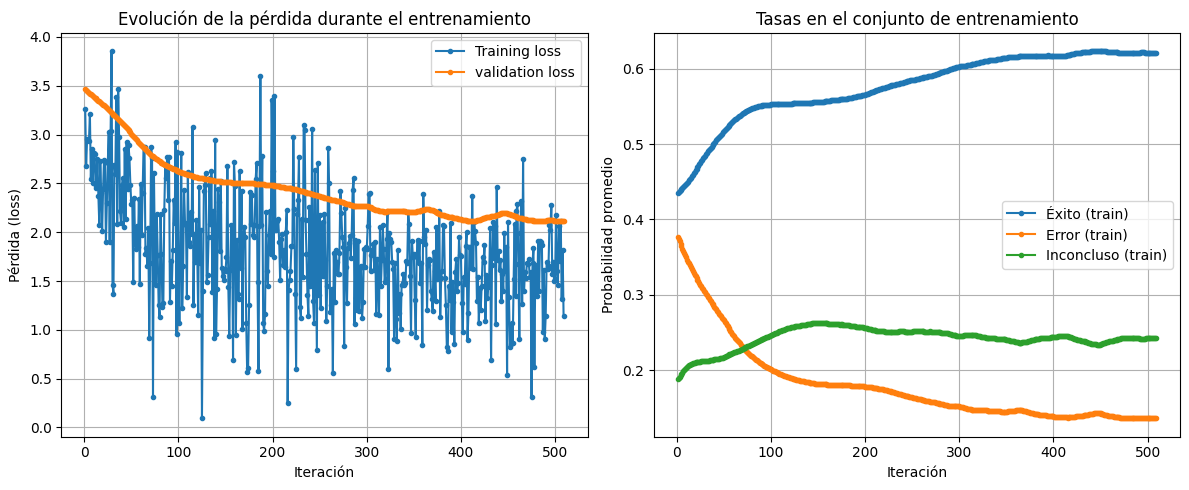

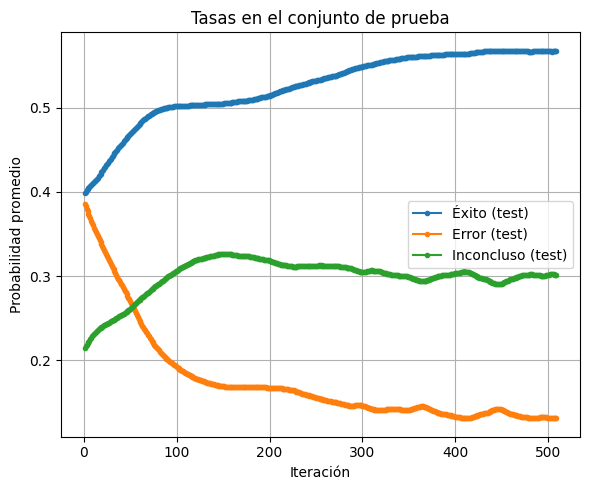

In [13]:
# Visualización de los resultados
plt.figure(figsize=(12,5))

# Evolución de la pérdida
plt.subplot(1,2,1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss")
plt.plot(range(1, it+1), val_loss_history, '.-', label="validation loss")
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la pérdida durante el entrenamiento")
plt.grid()
plt.legend()

# Éxito, Error e Inconcluso en train
plt.subplot(1,2,2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito (train)")
plt.plot(range(1, it+1), train_err_history, '.-', label="Error (train)")
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso (train)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de entrenamiento")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

# Figura para test
plt.figure(figsize=(6,5))

# Éxito, Error e Inconcluso en test
plt.plot(range(1, it+1), test_suc_history, '.-', label="Éxito (test)")
plt.plot(range(1, it+1), test_err_history, '.-', label="Error (test)")
plt.plot(range(1, it+1), test_inc_history, '.-', label="Inconcluso (test)")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas en el conjunto de prueba")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

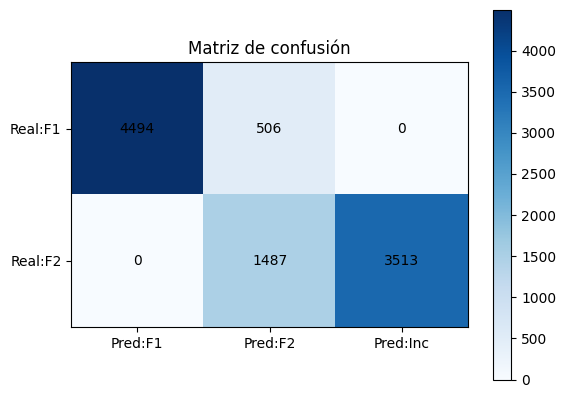

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
